In [7]:
air=pd.read_csv('demo/data/air_data.csv',encoding='utf-8')
air.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,ADD_Point_SUM,Eli_Add_Point_Sum,L1Y_ELi_Add_Points,Points_Sum,L1Y_Points_Sum,Ration_L1Y_Flight_Count,Ration_P1Y_Flight_Count,Ration_P1Y_BPS,Ration_L1Y_BPS,Point_NotFlight
0,54993,2006/11/02,2008/12/24,男,6,.,北京,CN,31.0,2014/03/31,...,39992,114452,111100,619760,370211,0.509524,0.490476,0.487221,0.512777,50
1,28065,2007/02/19,2007/08/03,男,6,NaN,北京,CN,42.0,2014/03/31,...,12000,53288,53288,415768,238410,0.514286,0.485714,0.489289,0.510708,33
2,55106,2007/02/01,2007/08/30,男,6,.,北京,CN,40.0,2014/03/31,...,15491,55202,51711,406361,233798,0.518519,0.481481,0.481467,0.518530,26
3,21189,2008/08/22,2008/08/23,男,5,Los Angeles,CA,US,64.0,2014/03/31,...,0,34890,34890,372204,186100,0.434783,0.565217,0.551722,0.448275,12
4,39546,2009/04/10,2009/04/15,男,6,贵阳,贵州,CN,48.0,2014/03/31,...,22704,64969,64969,338813,210365,0.532895,0.467105,0.469054,0.530943,39


In [3]:
#========数据探索：异常值（最值、空值）=========
explore=air.describe(percentiles=[],include='all').T
explore['null']=len(air)-explore['count']
explore=explore[['min','max','null']]
print(explore)#存在票价为空情况SUM_YR共689条，占比不大，可直接删除

                          min       max  null
MEMBER_NO                   1     62988     0
FFP_DATE                  NaN       NaN     0
FIRST_FLIGHT_DATE         NaN       NaN     0
GENDER                    NaN       NaN     3
FFP_TIER                    4         6     0
WORK_CITY                 NaN       NaN  2269
WORK_PROVINCE             NaN       NaN  3248
WORK_COUNTRY              NaN       NaN    26
AGE                         6       110   420
LOAD_TIME                 NaN       NaN     0
FLIGHT_COUNT                2       213     0
BP_SUM                      0    505308     0
EP_SUM_YR_1                 0         0     0
EP_SUM_YR_2                 0     74460     0
SUM_YR_1                    0    239560   551
SUM_YR_2                    0    234188   138
SEG_KM_SUM                368    580717     0
WEIGHTED_SEG_KM             0    558440     0
LAST_FLIGHT_DATE          NaN       NaN     0
AVG_FLIGHT_COUNT         0.25    26.625     0
AVG_BP_SUM                  0   63

In [8]:
#==============预处理：删除空值行及不符常理情况=========
air=air[air['SUM_YR_1'].notnull() & air['SUM_YR_2'].notnull()]

In [9]:
#去掉票价为零但折扣不为零、里程不为零的情况
index1=(air['SUM_YR_1']==0) | (air['SUM_YR_2']==0)
#air.loc[index1,['SUM_YR_1','SUM_YR_2']].head()
index2=(air['avg_discount']!=0) & (air['SEG_KM_SUM']!=0)
#air.loc[index2,['avg_discount','SEG_KM_SUM']].head()
air=air[-(index1 & index2)]#先确定目标所在行的索引，再进行筛选

In [10]:
air=air[['FLIGHT_COUNT','LAST_TO_END','avg_discount','SEG_KM_SUM','FFP_DATE','FIRST_FLIGHT_DATE','FFP_TIER','LOAD_TIME','AVG_INTERVAL']]
air.head()

,FLIGHT_COUNT,LAST_TO_END,avg_discount,SEG_KM_SUM,FFP_DATE,FIRST_FLIGHT_DATE,FFP_TIER,LOAD_TIME,AVG_INTERVAL
0,210,1,0.961639,580717,2006/11/02,2008/12/24,6,2014/03/31,3.483254
1,140,7,1.252314,293678,2007/02/19,2007/08/03,6,2014/03/31,5.194245
2,135,11,1.254676,283712,2007/02/01,2007/08/30,6,2014/03/31,5.298507
3,23,97,1.090870,281336,2008/08/22,2008/08/23,5,2014/03/31,27.863636
4,152,5,0.970658,309928,2009/04/10,2009/04/15,6,2014/03/31,4.788079


In [11]:
#将入会日期和首次飞行日期、结束转化为日期格式
#利用datetime.datetime.strptime将str转化为日期型
#其中第一个参数是str型的日期，第二个参数是str的日期格式
#经过转换后日期变成“年-月-日”的形式
air['FFP_trans']=air['FFP_DATE'].apply(lambda x:datetime.datetime.strptime(x,'%Y/%m/%d'))

air['FIRST_FLIGHT_trans']=air['FIRST_FLIGHT_DATE'].apply(lambda x:datetime.datetime.strptime(x,'%Y/%m/%d'))

air['LOAD_TIME_trans']=air['LOAD_TIME'].apply(lambda x:datetime.datetime.strptime(x,'%Y/%m/%d'))


In [34]:
datetime.datetime.strptime('2008/12/24','%Y/%m/%d').month#datetime格式返回年月日:直接用year/month/day属性

12

In [28]:
#定义间隔月份函数，没有现成函数，timedelta只能计算日、时分秒等间隔
def month_interval(begin,end):
    result=0
    try:
        if end.year>begin.year:
            year_interval=end.year-begin.year
            month_interval=12-begin.month+end.month
            result=(year_interval-1)*12+month_interval
        elif end.year==begin.year & end.month>begin.month:
            month_interval=end.month-begin.month
            result=month_interval
        else:
            result=0
    except Exception as e:
        print(e)
    return result

In [50]:
month_interval(datetime.datetime.strptime('2008/12/24','%Y/%m/%d'),datetime.datetime.strptime('2008/3/24','%Y/%m/%d'))

0

In [13]:
#通过抛出异常，使得循环继续进行
#匿名函数方式存在异常时无法继续执行
air['FFP_interval']=0
air['FIRST_FLIGHT_interval']=0
try:
    for i in range(0,len(air)):
        air.loc[i,'FFP_interval']=month_interval(air.loc[i,'FFP_trans'],air.loc[i,'LOAD_TIME_trans'])
        air.loc[i,'FIRST_FLIGHT_interval']=month_interval(air.loc[i,'FIRST_FLIGHT_trans'],air.loc[i,'LOAD_TIME_trans'])
except Exception as e:
    print(e)

# try:
#     #air['FFP_interval']=air.apply(lambda x:month_interval(x['FFP_trans'],x['LOAD_TIME_trans']))
#     air['FIRST_FLIGHT_interval']=air.apply(lambda x:month_interval(x['FIRST_FLIGHT_trans'],x['LOAD_TIME_trans']))
# except Exception as e:
#    print(e)    

'the label [132] is not in the [index]'


In [17]:
air.iloc[130:135,]

,FLIGHT_COUNT,LAST_TO_END,avg_discount,SEG_KM_SUM,FFP_DATE,FIRST_FLIGHT_DATE,FFP_TIER,LOAD_TIME,AVG_INTERVAL,FFP_trans,FIRST_FLIGHT_trans,LOAD_TIME_trans,FFP_interval,FIRST_FLIGHT_interval
130,27,38,0.780547,182561,2011/03/15,2012/05/27,6,2014/03/31,24.500000,2011-03-15,2012-05-27,2014-03-31,36,22
131,193,1,0.675610,209912,2004/11/30,2005/01/05,6,2014/03/31,3.781250,2004-11-30,2005-01-05,2014-03-31,112,110
133,14,59,0.973673,144708,2012/04/11,2012/07/30,4,2014/03/31,42.461538,2012-04-11,2012-07-30,2014-03-31,0,0
134,24,11,0.658634,213058,2009/10/19,2010/01/28,5,2014/03/31,30.739130,2009-10-19,2010-01-28,2014-03-31,0,0
135,89,17,0.787337,177556,2010/10/09,2010/10/10,6,2014/03/31,7.965909,2010-10-09,2010-10-10,2014-03-31,0,0


In [21]:
#由于缺少index为132的行，所以循环执行不下去，即便采用了try...catch，也只能计算index小于132的值，剩余行全部未执行
#因此，采用重新定义index的方法，使得其成为从0-len连续的整数

data={'FFP_trans':pd.Series(air["FFP_trans"].values),'LOAD_TIME_trans':pd.Series(air["LOAD_TIME_trans"].values),
      'FIRST_FLIGHT_trans':pd.Series(air["FIRST_FLIGHT_trans"].values),'FLIGHT_COUNT':pd.Series(air["FLIGHT_COUNT"].values),
      'LAST_TO_END':pd.Series(air["LAST_TO_END"].values),'avg_discount':pd.Series(air["avg_discount"].values),
      'SEG_KM_SUM':pd.Series(air["SEG_KM_SUM"].values)}
air_book=pd.DataFrame(data)
air_book.iloc[130:135]

,FFP_trans,FIRST_FLIGHT_trans,FLIGHT_COUNT,LAST_TO_END,LOAD_TIME_trans,SEG_KM_SUM,avg_discount
130,2011-03-15,2012-05-27,27,38,2014-03-31,182561,0.780547
131,2004-11-30,2005-01-05,193,1,2014-03-31,209912,0.675610
132,2012-04-11,2012-07-30,14,59,2014-03-31,144708,0.973673
133,2009-10-19,2010-01-28,24,11,2014-03-31,213058,0.658634
134,2010-10-09,2010-10-10,89,17,2014-03-31,177556,0.787337


In [77]:
#air_book['FFP_interval']=0
#air_book['FIRST_FLIGHT_interval']=0
#法一：循环速度太慢了
# try:
#     for i in range(0,len(air_book)):
#         air_book.loc[i,'FFP_interval']=month_interval(air_book.loc[i,'FFP_trans'],air_book.loc[i,'LOAD_TIME_trans'])
#         air_book.loc[i,'FIRST_FLIGHT_interval']=month_interval(air_book.loc[i,'FIRST_FLIGHT_trans'],air_book.loc[i,'LOAD_TIME_trans'])
# except Exception as e:
#     print(e)
#法二：lambda函数对dataframe各列迭代时默认index是行，所以用axis指定index为列
air_book=air[['FFP_trans','LOAD_TIME_trans','FIRST_FLIGHT_trans','FLIGHT_COUNT','LAST_TO_END','avg_discount','SEG_KM_SUM']]
air_book['FFP_interval']=air_book.apply(lambda x:month_interval(x['FFP_trans'],x['LOAD_TIME_trans']),axis=1)
air_book['FIRST_FLIGHT_interval']=air_book.apply(lambda x:month_interval(x['FIRST_FLIGHT_trans'],x['LOAD_TIME_trans']),axis=1)
air_book.head()

E:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
E:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,FFP_trans,LOAD_TIME_trans,FIRST_FLIGHT_trans,FLIGHT_COUNT,LAST_TO_END,avg_discount,SEG_KM_SUM,FFP_interval,FIRST_FLIGHT_interval
0,2006-11-02,2014-03-31,2008-12-24,210,1,0.961639,580717,88,63
1,2007-02-19,2014-03-31,2007-08-03,140,7,1.252314,293678,85,79
2,2007-02-01,2014-03-31,2007-08-30,135,11,1.254676,283712,85,79
3,2008-08-22,2014-03-31,2008-08-23,23,97,1.090870,281336,67,67
4,2009-04-10,2014-03-31,2009-04-15,152,5,0.970658,309928,59,59


In [78]:
air_book_select=air_book[['FFP_interval','FLIGHT_COUNT','LAST_TO_END','avg_discount','SEG_KM_SUM']]
air_book_select=(air_book_select-air_book_select.mean())/air_book_select.std()#标准化
air_book_select.tail()

,FFP_interval,FLIGHT_COUNT,LAST_TO_END,avg_discount,SEG_KM_SUM
62982,-1.282138,-0.872764,3.427862,-4.156931,-0.791311
62983,-0.572505,-0.872764,1.998106,-4.156931,-0.906374
62984,-0.075761,-0.745479,-0.126102,-4.156931,-0.614603
62985,1.627358,-0.872764,-0.738855,-4.156931,-0.844476
62986,-1.317619,-0.872764,3.049998,-4.156931,-0.787665


In [80]:
#air_book.head()
air_book_select.to_csv('demo/data/air_preceed.csv',index=False)

In [81]:
k=5
kmodel=KMeans(init='k-means++',n_clusters=k,n_jobs=4,n_init=10)#定义模型聚为5类，cpu并行数为4,init快速选择初始类中心，n_init训练次数，寻找最优结果
kmodel.fit(air_book_select)
kmodel.cluster_centers_#查看类中心

array([[ 1.13416780e+00, -8.44679402e-02, -3.17634757e-01,
        -1.31264757e-01, -9.22127163e-02],
       [-7.07104742e-01, -1.75335571e-01, -4.59160581e-01,
        -2.01333307e-01, -1.75675561e-01],
       [ 2.11321082e-01, -1.73717322e-02, -1.08647088e-01,
         2.96578018e+00, -2.57227467e-03],
       [ 4.76873869e-01,  2.33194664e+00, -8.11772111e-01,
         2.48864451e-01,  2.25332254e+00],
       [-3.44838952e-01, -5.83382676e-01,  1.52603923e+00,
        -1.85591209e-01, -5.43387724e-01]])

In [60]:
#获得每个客户所属类别
kmodel.labels_

array([4, 4, 4, ..., 0, 2, 1])

In [82]:
air_book_select['label']=kmodel.predict(air_book_select)

In [83]:
air_book_select.head()

,FFP_interval,FLIGHT_COUNT,LAST_TO_END,avg_discount,SEG_KM_SUM,label
0,1.343505,12.364835,-1.024806,1.319222,23.665810,3
1,1.237060,7.909874,-0.963531,2.974504,11.496413,3
2,1.237060,7.591662,-0.922681,2.987949,11.073892,3
3,0.598390,0.463725,-0.044402,2.055139,10.973158,3
4,0.314537,8.673581,-0.983956,1.370581,12.185354,3


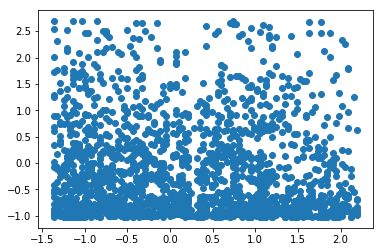

In [88]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(air_book_select.loc[air_book_select['label']==2,'FFP_interval'],air_book_select.loc[air_book_select['label']==2,'LAST_TO_END'])
plt.show()

In [106]:
# air_book=air_book[['FFP_interval','FLIGHT_COUNT','LAST_TO_END','avg_discount','SEG_KM_SUM']]
# air_book=pd.concat([air_book,air_book_select['label']],axis=1)
air_book=pd.concat([air_book,air['AVG_INTERVAL']],axis=1)
air_book.head()
#air_book.to_csv('demo/data/air_pre_zero.csv',index=False)

,FFP_interval,FLIGHT_COUNT,LAST_TO_END,avg_discount,SEG_KM_SUM,label,AVG_INTERVAL
0,88,210,1,0.961639,580717,3,3.483254
1,85,140,7,1.252314,293678,3,5.194245
2,85,135,11,1.254676,283712,3,5.298507
3,67,23,97,1.090870,281336,3,27.863636
4,59,152,5,0.970658,309928,3,4.788079


In [99]:
cluster=pd.DataFrame(kmodel.cluster_centers_)

In [100]:
cluster.columns=['FFP_interval','FLIGHT_COUNT','LAST_TO_END','avg_discount','SEG_KM_SUM']
cluster

,FFP_interval,FLIGHT_COUNT,LAST_TO_END,avg_discount,SEG_KM_SUM
0,1.134168,-0.084468,-0.317635,-0.131265,-0.092213
1,-0.707105,-0.175336,-0.459161,-0.201333,-0.175676
2,0.211321,-0.017372,-0.108647,2.965780,-0.002572
3,0.476874,2.331947,-0.811772,0.248864,2.253323
4,-0.344839,-0.583383,1.526039,-0.185591,-0.543388


In [117]:
cluster['age_mean']=0
cluster['interval_mean']=0
cluster['last_mean']=0
for i in range(0,5):
    cluster.loc[i,'age_mean']=air_book.loc[air_book['label']==i,'FFP_interval'].mean()
    cluster.loc[i,'interval_mean']=air_book.loc[air_book['label']==i,'AVG_INTERVAL'].mean()
    cluster.loc[i,'last_mean']=air_book.loc[air_book['label']==i,'LAST_TO_END'].mean()

In [118]:
cluster

,FFP_interval,FLIGHT_COUNT,LAST_TO_END,avg_discount,SEG_KM_SUM,age_mean,interval_mean,last_mean
0,1.134168,-0.084468,-0.317635,-0.131265,-0.092213,82.094053,71.322361,70.263236
1,-0.707105,-0.175336,-0.459161,-0.201333,-0.175676,30.205379,79.615923,56.383927
2,0.211321,-0.017372,-0.108647,2.965780,-0.002572,56.107163,75.987564,90.657413
3,0.476874,2.331947,-0.811772,0.248864,2.253323,63.584316,15.261640,21.857509
4,-0.344839,-0.583383,1.526039,-0.185591,-0.543388,40.406338,98.842238,250.776536


In [116]:
air_book.loc[air_book['label']==2,'AVG_INTERVAL'].describe()

count    1801.000000
mean       75.987564
std        88.464040
min         3.000000
25%        28.875000
50%        47.166667
75%        85.800000
max       714.000000
Name: AVG_INTERVAL, dtype: float64